In [2]:
import os, sys, json
import argparse
import platform
import shutil

import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.nn.init import xavier_uniform_, zeros_
from PyQt5.QtWidgets import QApplication
from torchvision.models import vgg16_bn

from datasets import Train_Meta_Dataset, Val_Meta_Dataset, Test_Meta_Dataset, Random_Affine, ToTensor, Normalise, collate_fn
from meta_function import meta_loading

In [3]:
fileDir = "C:/fully_split_data/"
t1MapDir = "C:/T1_Maps/"
modelName = "Not_Norm_Condense"
condense = True
bSize = 4
normQ = False

modelDir = "./models/VGG_16/{}/".format(modelName)
assert os.path.isdir(modelDir), "Model Directory is not found, please check your model name!"


figDir = "{}Test_Figures/".format(modelDir)
try:
    os.makedirs(figDir)
except FileExistsError as e:
    print(e, "This means you will be overwriting previous results!")

toT = ToTensor()

if normQ:
    norm = Normalise()
    trnsInTest = transforms.Compose([toT,norm])
else:
    trnsInTest = transforms.Compose([toT])

In [4]:
datasetTest = Test_Meta_Dataset(modelDir=modelDir,fileDir=fileDir,t1MapDir=t1MapDir,size=1000,transform=trnsInTest,load=True,condense=condense)
loaderTest = DataLoader(datasetTest,batch_size=bSize,shuffle=False,collate_fn=collate_fn,pin_memory=False)

batch = next(iter(loaderTest))
inpMetaSize = batch['Meta'].size()[1]
if condense:
    outSize = 1
else:
    outSize = batch["Tag"].size()[1]

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

net = vgg16_bn(pretrained=False)
numFtrs = net.classifier[6].in_features
net.classifier[6] = nn.Linear(numFtrs,outSize)
numChannels = net.features[0].out_channels
net.features[0] = nn.Conv2d(7, numChannels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

modelDict = torch.load("{}model.pt".format(modelDir),map_location=device)
net.load_state_dict(modelDict["state_dict"])
net = net.to(device)

testLen = datasetTest.__len__()

testLossCnt = 0


 Loading Meta Data.... 

 [31199/31199]


In [6]:
pred = np.zeros((1000,outSize))
y_test = np.zeros((1000,outSize))
with torch.no_grad():
    net.eval()
    for i,data in enumerate(loaderTest):
        inpData = data["Images"].to(device)
        eid = data["eid"]
        inpMeta = data["Meta"].to(device)
        y_test[i*bSize:(i+1)*bSize,:] = data["Tag"].numpy()

        out = net(inpData)

        out = torch.sigmoid(out)

        pred[i*bSize:(i+1)*bSize,:] = out.cpu().numpy()

        sys.stdout.write("\r\tSubj {}/{}".format(i*bSize,testLen))

	Subj 996/1000

C:\Users\shug4421\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\shug4421\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


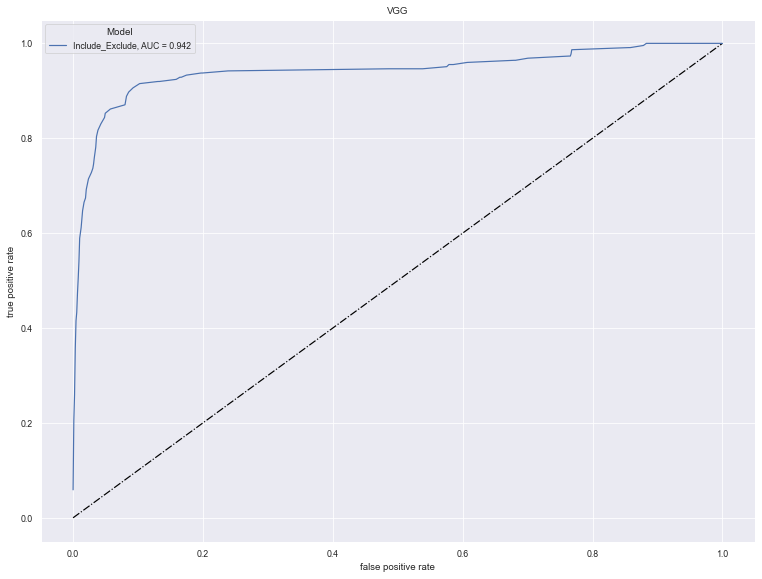

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score
import pandas
import seaborn as sns

plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")

modelsArr = []
fprArr = []
tprArr = []

# tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']
tagNames = ["Include_Exclude"]

for i,name in enumerate(tagNames):
    try:
        fpr,tpr,_ = roc_curve(y_test[:,i],pred[:,i])
        auc_score = roc_auc_score(y_test[:,i],pred[:,i])

        event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

        modelsArr.extend(event)
        fprArr.extend(fpr)
        tprArr.extend(tpr)
    except ValueError as e:
        print(name,e)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)
df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("VGG")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model",ci=None)
plt.show()